<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />
  
# Capacidades de Analítica Avanzada en la Base de Datos 
# (In-Database)

## Caso 6: Detección de DAM Anómalas
    
![Slide](images/Diapositiva5.PNG)


## **Instalar las librerías**

In [ ]:
#!pip install teradataml==17.20.0.4 sklearn2pmml==0.95.1

## **Carga de Modulos**

In [2]:
import pandas as pd
import numpy as np
import getpass as gp
import plotly.express as px
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import kds

from teradataml import *
from teradataml.analytics.valib import *
configure.val_install_location = "val"

C:\TDAPPS\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
con=create_context(host = "40.121.65.25", database="DW_LANDING", username="pocuser", password = gp.getpass())

 ········


![Slide](images/Diapositiva10.PNG)

## **Lectura Inicial de base de datos**

In [3]:
# Leemos la data de desarrollo de modelos
tdf = DataFrame(in_schema("DW_LANDING","V_KPIS_ADUANAS_ALL"))

In [4]:
# Primeros Registros
tdf.head(10)

DAM_RECOD,SERIE,IMPORTADOR,TIPO_UNIDADES_FISICA,AGENTE_ADUANA,DEPOSITO,PAIS_ORIGEN,PARTIDA_ARANCELARIA,CAPITULO,FOB,PESO_NETO,VALOR_FOB_PROM,CANTIDAD_UNIDAD_FISICA
202200000006220,1,20000005799,KG,7053,9998,EC,1905901000,19,26213.6,13763.52,1.9045709237171884,None
202200000006221,2,20000005799,KG,7053,9998,EC,1905901000,19,26216.455,13763.52,1.9047783561182023,None
202200000006222,1,20000011001,KG,7774,4410,EC,0713609000,07,87750.0,97300.0,0.9018499486125385,97300
202200000006223,2,20000005799,KG,7053,9998,EC,1905310000,19,851.037,336.57,2.528558695070862,None
202200000006223,4,20000005799,KG,7053,9998,EC,1905901000,19,11320.334,5538.96,2.043765255571443,None
202200000006223,3,20000005799,KG,7053,9998,EC,1905901000,19,13483.619,7080.0,1.9044659604519776,7080
202200000006223,1,20000005799,KG,7053,9998,EC,1905310000,19,615.53,254.2,2.4214398111723052,None
202200000006221,1,20000005799,KG,7053,9998,EC,1905901000,19,25987.195,13643.16,1.9047782918326839,None
202200000006219,1,20000011174,KG,7774,4410,EC,2309909000,23,57392.799,54250.0,1.0579317788018432,54250
202200000006219,2,20000011174,KG,7774,4410,EC,2309909000,23,88649.901,90000.0,0.9849989,90000


In [5]:
# Vemos la dimensionalidad
tdf.shape

(1949962, 13)

## **Exploración de los datos**

In [6]:
# Estadísticas Descriptivas por Columna
valS = valib.Statistics(data=tdf, extended_options="all", columns="allnumeric")
valS.result.head(21).sort('xcol')

xdb,xtbl,xcol,xcnt,xmin,xmax,xmean,xstd,xtype,xnull,xnique,xblank,xzero,xpos,xneg,xmode,xmode_cnt,xmode_pct,xnbrmodes,xpctile0,xpctile1,xpctile2,xpctile3,xpctile4,xpctile5,xpctile6,xpctile7,xpctile8,xpctile9,xpctile10,xpctile20,xpctile25,xpctile30,xpctile33,xpctile40,xpctile50,xpctile60,xpctile67,xpctile70,xpctile75,xpctile80,xpctile90,xpctile91,xpctile92,xpctile93,xpctile94,xpctile95,xpctile96,xpctile97,xpctile98,xpctile99,xpctile100,xmin_1,xmin_2,xmin_3,xmin_4,xmin_5,xmincnt_1,xmincnt_2,xmincnt_3,xmincnt_4,xmincnt_5,xmax_5,xmax_4,xmax_3,xmax_2,xmax_1,xmaxcnt_5,xmaxcnt_4,xmaxcnt_3,xmaxcnt_2,xmaxcnt_1
DW_LANDING,V_KPIS_ADUANAS_ALL,CANTIDAD_UNIDAD_FISICA,1604946.0,0.0,850000000.0,7379.898718710785,1224920.561258553,INTEGER,345016.0,17177.0,None,2821.0,1602125.0,0.0,1.0,427287.0,21.912580860550104,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,8.0,15.0,28.0,40.0,62.0,120.0,600.0,800.0,1000.0,1224.0,1800.0,2400.0,3896.0,7000.0,15750.0,35000.0,850000000.0,0.0,1.0,2.0,3.0,4.0,2821.0,427287.0,132140.0,61768.0,58863.0,496000000.0,550000000.0,554500000.0,700000000.0,850000000.0,1.0,1.0,1.0,1.0,1.0
DW_LANDING,V_KPIS_ADUANAS_ALL,FOB,1949962.0,0.0,58359665.82,4427.195965782367,144417.6815011417,FLOAT,0.0,624810.0,None,2821.0,1947141.0,0.0,74.2,3054.0,0.15661843666697095,1.0,0.0,1.2,2.513,3.74,5.0,6.193,7.598,8.98,10.36,12.0,13.554,36.82,53.538,72.891,87.125,128.1,215.956,375.0,570.0,688.93,955.81,1427.257,4695.387,5605.142,6739.2,8096.4,9639.0,11855.09,15249.15,20497.92,28691.0,51827.04,58359665.82,0.0,0.001,0.002,0.003,0.004,2821.0,3.0,8.0,11.0,1.0,40787629.0,41260151.93,47498746.4,58205476.09,58359665.82,1.0,1.0,1.0,1.0,1.0
DW_LANDING,V_KPIS_ADUANAS_ALL,IMPORTADOR,1949962.0,10000000022.0,20000038108.0,19784821632.070152,1451081166.513622,BIGINT,0.0,19052.0,None,0.0,1949962.0,0.0,20000005590.0,82678.0,4.239980061149909,1.0,10000000022.0,10000002217.0,10000005089.0,20000005590.0,20000005590.0,20000005590.0,20000005590.0,20000005590.0,20000005660.0,20000005685.0,20000005718.0,20000006392.0,20000007071.0,20000008050.0,20000008437.0,20000009641.0,20000012941.0,20000016545.0,20000018456.0,20000019036.0,20000021220.0,20000024171.0,20000032052.0,20000032933.0,20000033420.0,20000034491.0,20000034953.0,20000035337.0,20000036087.0,20000036382.0,20000037171.0,20000037905.0,20000038108.0,10000000022.0,10000000025.0,10000000028.0,10000000030.0,10000000033.0,2.0,4.0,50.0,160.0,115.0,20000038104.0,20000038105.0,20000038106.0,20000038107.0,20000038108.0,1.0,5.0,16.0,84.0,1.0
DW_LANDING,V_KPIS_ADUANAS_ALL,PESO_NETO,1949962.0,0.0,91564440.0,3159.8887761059696,209620.36656498935,FLOAT,0.0,324952.0,None,2821.0,1947141.0,0.0,0.037,7016.0,0.35980188331875185,1.0,0.0,0.013,0.032,0.047,0.074,0.101,0.132,0.157,0.19,0.22,0.251,0.696,1.111,1.704,2.159,3.849,8.696,20.71,39.361,52.73,91.971,137.314,624.0,792.0,996.439,1184.728,1460.0,1905.96,2589.789,4345.0,8948.661,22344.0,91564440.0,0.0,0.001,0.002,0.003,0.004,2821.0,1857.0,1268.0,1060.0,1168.0,44451240.0,53815412.0,60996604.0,91317925.0,91564440.0,1.0,1.0,1.0,1.0,1.0
DW_LANDING,V_KPIS_ADUANAS_ALL,SERIE,1949962.0,1.0,7406.0,235.23639999138445,620.0274154415514,INTEGER,0.0,7406.0,None,0.0,1949962.0,0.0,1.0,127801.0,6.554025155362002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,7.0,10.0,14.0,17.0,25.0,43.0,71.0,103.0,121.0,163.0,228.0,529.0,594.0,675.0,778.0,922.0,1110.0,1373.0,1815.0,2461.0,3396.0,7406.0,1.0,2.0,3.0,4.0,5.0,127801.0,66504.0,54093.0,46811.0,41445.0,7402.0,7403.0,7404.0,7405.0,7406.0,1.0,1.0,1.0,1.0,1.0
DW_LANDING,V_KPIS_ADUANAS_ALL,VALOR_FOB_PROM,1949962.0,0.0,8527317.4,233.26168511190016,10672.493121877276,FLOAT,0.0,1285100.0,None,2821.0,1947141.0,0.0,196.2962962962963,2998.0,0.15374658583090337,1.0,0.0,0.5191887959257911,0.8513157894736842,1.1446504313931194,1.394905388846143,1.6299915038232795,1.9060844940026411,2.161134163208852,2.4228524514952854,2.656403112123824,2.9047046570304587,5.474528925619835,7.020836477987422,9.041336851363237,10.411866359447004,14.717662337662

In [7]:
pd.read_sql("select top 10 DAM_RECOD, SERIE, FOB, PESO_NETO, VALOR_FOB_PROM from DW_LANDING.V_KPIS_ADUANAS_ALL order by fob desc", con)

,DAM_RECOD,SERIE,FOB,PESO_NETO,VALOR_FOB_PROM
0,202200000493321,1,58359665.82,91317925.0,0.639082
1,202200000519076,1,58205476.09,91564440.0,0.635678
2,202200000450531,1,47498746.40,40681696.0,1.167570
3,202200000525383,1,41260151.93,39704479.0,1.039181
4,202200000473692,1,40787629.00,60996604.0,0.668687
5,202200000525446,1,38872936.38,40243865.0,0.965934
6,202200000473904,1,37214735.80,31300801.0,1.188939
7,202200000446168,1,35424001.79,31119426.0,1.138324
8,202200000492290,1,35168296.04,39364568.0,0.893400
9,202200000524257,1,29616520.75,26439735.0,1.120152


In [8]:
pd.read_sql("select top 10 DAM_RECOD, SERIE, FOB, PESO_NETO, VALOR_FOB_PROM from DW_LANDING.V_KPIS_ADUANAS_ALL order by PESO_NETO desc", con)

,DAM_RECOD,SERIE,FOB,PESO_NETO,VALOR_FOB_PROM
0,202200000519076,1,5.820548e+07,91564440.0,0.635678
1,202200000493321,1,5.835967e+07,91317925.0,0.639082
2,202200000473692,1,4.078763e+07,60996604.0,0.668687
3,202200000500628,1,2.946412e+07,53815412.0,0.547503
4,202200000436285,1,1.717507e+07,44451240.0,0.386380
5,202200000011182,1,2.156000e+06,44000000.0,0.049000
6,202200000456607,1,1.874889e+06,43602070.0,0.043000
7,202200000450531,1,4.749875e+07,40681696.0,1.167570
8,202200000525446,1,3.887294e+07,40243865.0,0.965934
9,202200000525383,1,4.126015e+07,39704479.0,1.039181


In [9]:
pd.read_sql("select top 10 DAM_RECOD, SERIE, FOB, PESO_NETO, VALOR_FOB_PROM from DW_LANDING.V_KPIS_ADUANAS_ALL order by VALOR_FOB_PROM desc", con)

,DAM_RECOD,SERIE,FOB,PESO_NETO,VALOR_FOB_PROM
0,202200000444129,8,85273.174,0.010,8527317.4
1,202200000744982,19,4823.528,0.001,4823528.0
2,202200000739486,1,3140.988,0.001,3140988.0
3,202200000721159,1,3129.690,0.001,3129690.0
4,202200000738295,75,2810.623,0.001,2810623.0
5,202200000738295,74,2810.623,0.001,2810623.0
6,202200000744982,17,2800.000,0.001,2800000.0
7,202200000743947,29,2537.970,0.001,2537970.0
8,202200000719935,11,1929.737,0.001,1929737.0
9,202200000719935,10,1790.817,0.001,1790817.0


### Escalado

In [6]:
fit_scal = ScaleFit(data=tdf,
                   target_columns=['FOB','PESO_NETO','VALOR_FOB_PROM'],
                   scale_method="RANGE",
                   miss_value="KEEP",
                   global_scale=False)
fit_scal.output

TD_STATTYPE_SCLFIT,FOB,PESO_NETO,VALOR_FOB_PROM
null,0.0,0.0,0.0
count,1949962.0,1949962.0,1949962.0
max,58359665.82,91564440.0,8527317.4
avg,4427.195965782368,3159.8887761059696,233.26168511190008
location,0.0,0.0,0.0
missvalue_KEEP,None,None,None
scale,58359665.82,91564440.0,8527317.4
globalscale_false,None,None,None
multiplier,1.0,1.0,1.0
intercept,0.0,0.0,0.0


In [7]:
## Aplicando la transformación
scal = ScaleTransform(data=tdf, 
                     object=fit_scal.output,
                     accumulate=['DAM_RECOD'])

In [12]:
scal.result.head()

DAM_RECOD,FOB,PESO_NETO,VALOR_FOB_PROM
202200000006220,0.00044917323688677694,0.00015031512233351724,2.233493646802907e-07
202200000006221,0.0004452937595659454,0.0001490006382390369,2.233736827753924e-07
202200000006222,0.001503606964965311,0.0010626396011377342,1.0576010089791409e-07
202200000006223,1.0547181711055246e-05,2.776186912735992e-06,2.8396266933517745e-07
202200000006223,0.00023104345802095274,7.732259379296155e-05,2.2333705561985736e-07
202200000006223,1.4582622913312632e-05,3.6757719481493034e-06,2.9652451954830035e-07
202200000006223,0.00019397530539183613,6.0492479394839306e-05,2.3967270827416874e-07
202200000006221,0.00044922215766039493,0.00015031512233351724,2.2337369031416636e-07
202200000006219,0.000983432618977255,0.0005924789143034129,1.2406384436937263e-07
202200000006219,0.0015190268784853024,0.0009829143278766298,1.1551099294134401e-07


In [13]:
copy_to_sql(scal.result, schema_name="DW_LANDING", table_name="caso6_scal", primary_index="DAM_RECOD", if_exists="replace")

### Matriz de correlaciones

In [14]:
## Función de VAL para el cálculo In-Database de la matriz de correlaciones
Cor_Mat = valib.Matrix(data=scal.result, columns="allnumeric", exclude_columns=["DAM_RECOD"], type="COR")
## Imprimir los resultados
Cor_Mat.result.sort('rownum').head(21)

rownum,rowname,FOB,PESO_NETO,VALOR_FOB_PROM
1,FOB,1.0,0.8662556452933109,0.00039506923401489054
2,PESO_NETO,0.8662556452933109,1.0,-0.00032749105155652414
3,VALOR_FOB_PROM,0.00039506923401489054,-0.00032749105155652414,1.0


<Axes: ylabel='rownum-rowname'>

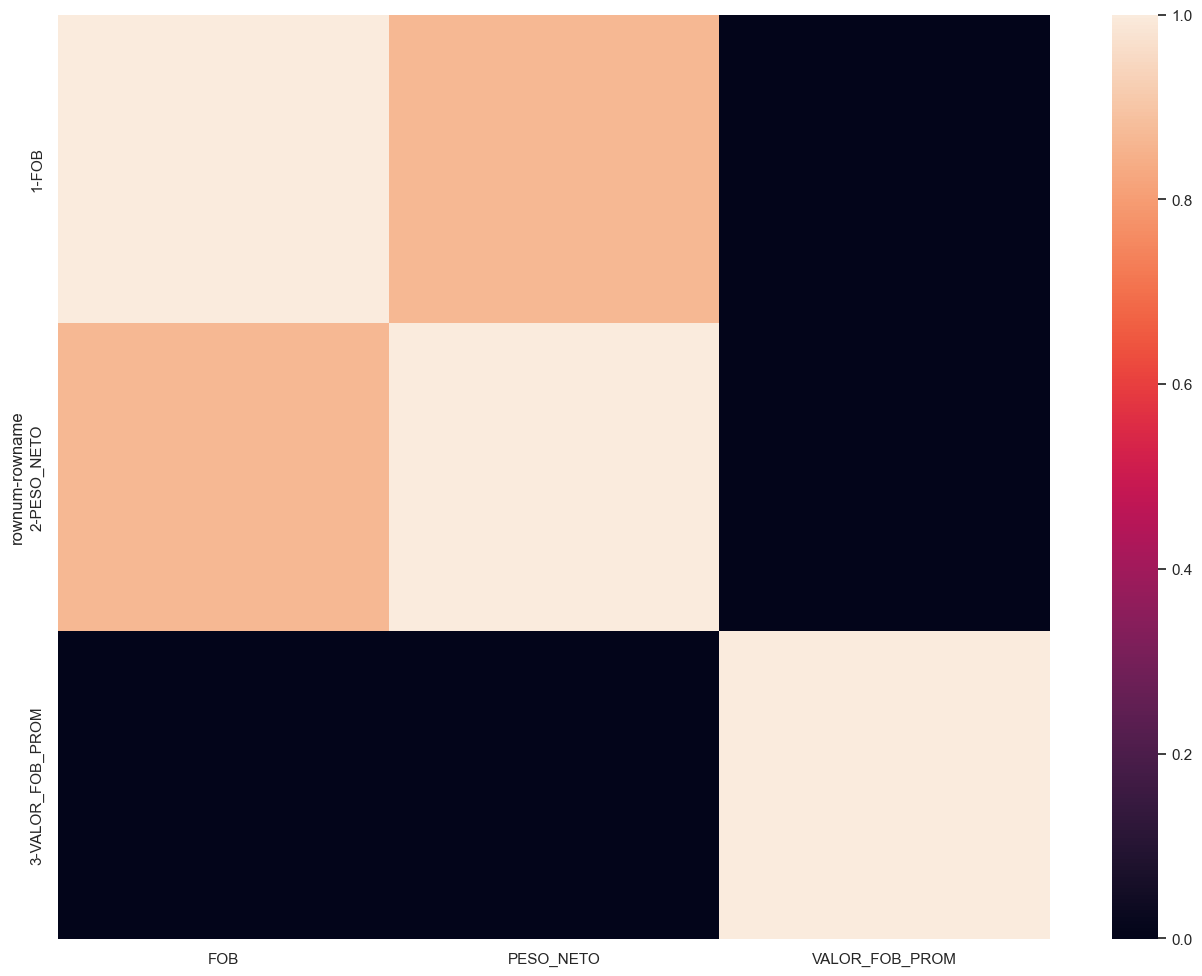

In [15]:
## Graficando la Matriz de Correlaciones - Más claro significa correlación más alta
sns.set(rc = {'figure.figsize':(16,12)})
sns.heatmap(Cor_Mat.result.to_pandas().sort_values(['rownum']))

### Particion Muestral

In [8]:
###'SERIE', 
tbl_sample = scal.result.sample(frac = [0.2, 0.8])

In [9]:
copy_to_sql(tbl_sample[tbl_sample.sampleid == "1"].drop("sampleid", axis = 1), schema_name="DW_LANDING", table_name="TrainIF", primary_index="DAM_RECOD", if_exists="replace")
tbl_train = DataFrame(in_schema("DW_LANDING","TrainIF"))
tbl_train.shape

(389992, 4)

In [10]:
copy_to_sql(tbl_sample[tbl_sample.sampleid == "2"].drop("sampleid", axis = 1), schema_name="DW_LANDING", table_name="TestIF", primary_index="DAM_RECOD", if_exists="replace")
tbl_test = DataFrame(in_schema("DW_LANDING","TestIF"))
tbl_test.shape

(1559970, 4)

### Moviendo los Datos A Python

In [19]:
sub_sample = tbl_train.to_pandas(all_rows=True)

In [20]:
sub_sample.head(5)

,FOB,PESO_NETO,VALOR_FOB_PROM
DAM_RECOD,,,
202200000500965,4.441424e-06,8.534536e-07,3.889697e-07
202200000522797,3.351630e-04,1.357514e-04,1.845378e-07
202200000493126,7.611079e-05,2.184254e-06,2.604453e-06
202200000479883,4.494543e-08,1.168576e-09,2.874763e-06
202200000522045,1.268427e-05,3.480227e-06,2.724154e-07


In [22]:
def plot_num(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=sub_sample,x=feature,ax=axes[0])
    sns.distplot(a=sub_sample[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)

C:\Users\lc250058\AppData\Local\Temp\ipykernel_20436\3305979841.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=sub_sample[feature],ax=axes[1],color='#ff4125')


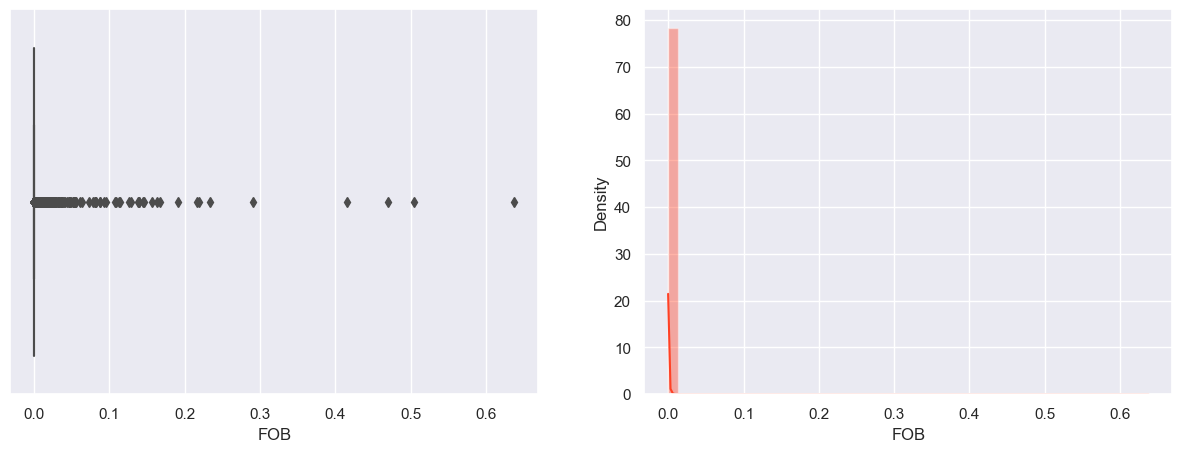

In [23]:
plot_num('FOB')

C:\Users\lc250058\AppData\Local\Temp\ipykernel_20436\3305979841.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=sub_sample[feature],ax=axes[1],color='#ff4125')


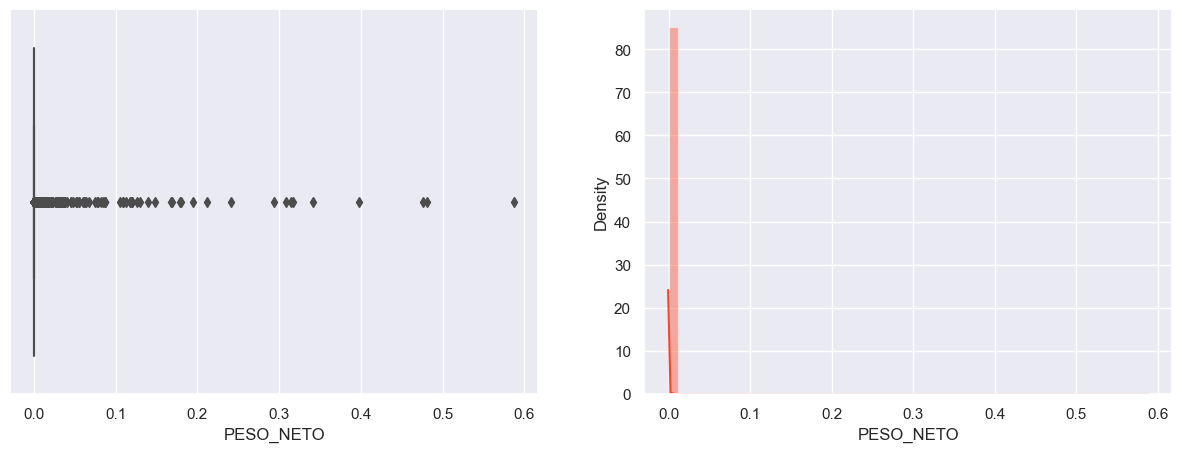

In [24]:
plot_num('PESO_NETO')

C:\Users\lc250058\AppData\Local\Temp\ipykernel_20436\3305979841.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=sub_sample[feature],ax=axes[1],color='#ff4125')


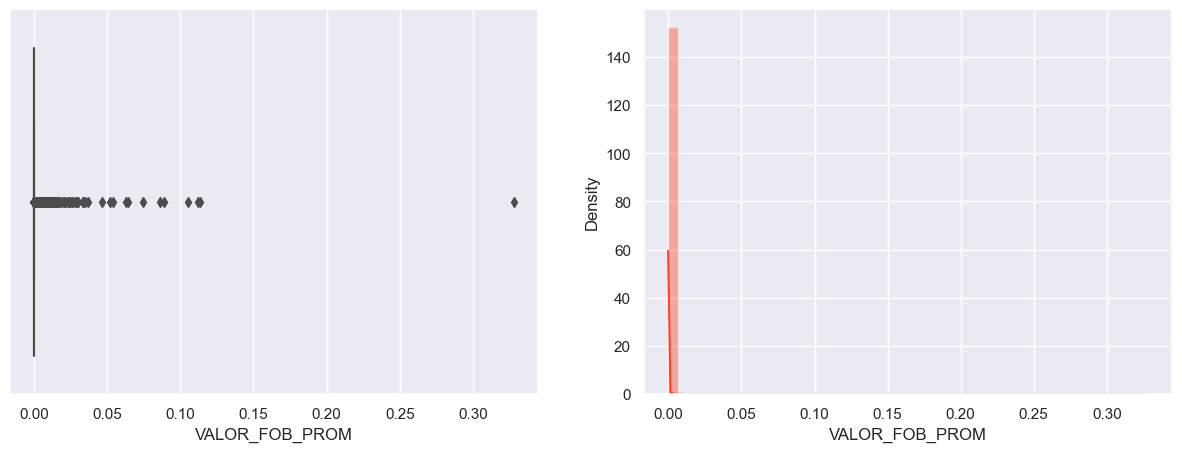

In [25]:
plot_num('VALOR_FOB_PROM')

## **Entrenamiento de un Modelo Isolation Forest**

In [26]:
clf = IsolationForest(n_estimators=100, max_samples=100, contamination=0.01,random_state=123, n_jobs=-1)
clf.fit(sub_sample)

C:\TDAPPS\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_samples=100, n_jobs=-1,
                random_state=123)

In [33]:
y_sub = clf.predict(sub_sample)
y_sub.shape

In [39]:
unique, counts = np.unique(y_sub, return_counts=True)
dict(zip(unique, counts))

{-1: 3877, 1: 386115}

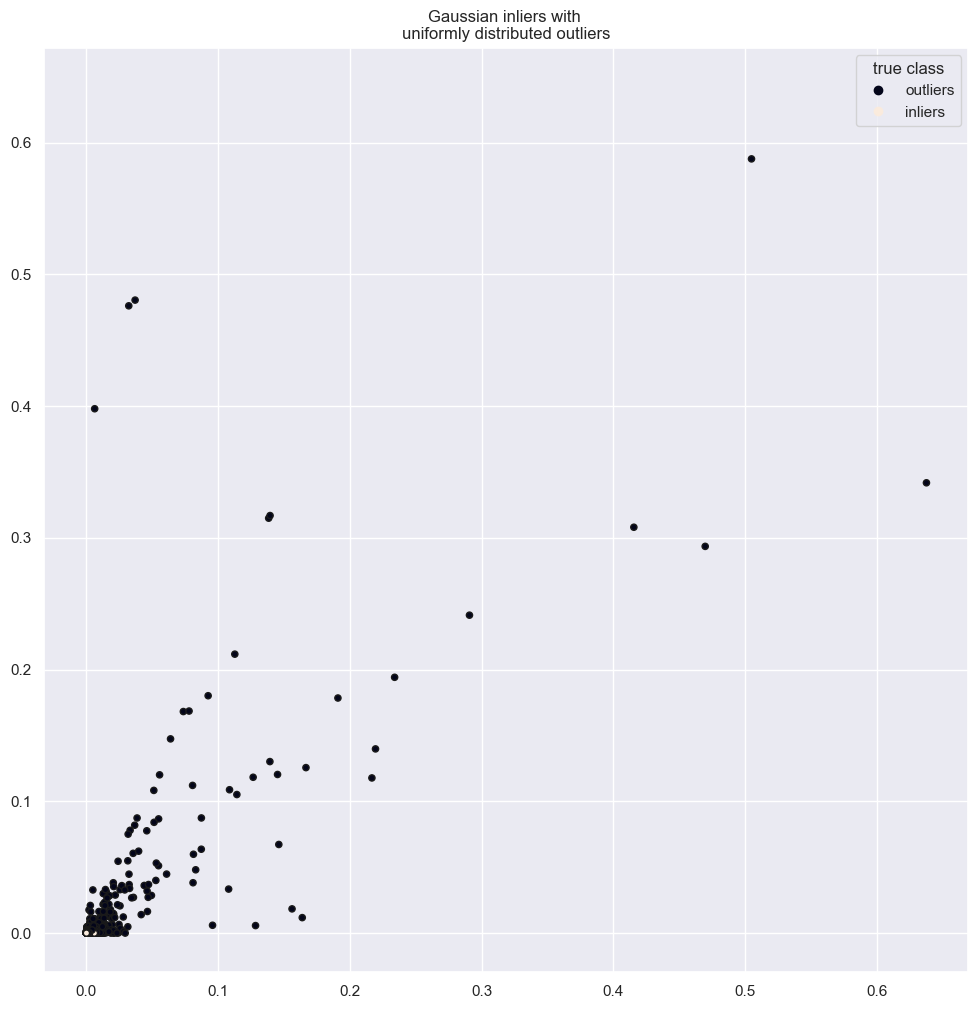

In [34]:
from sklearn.inspection import DecisionBoundaryDisplay
scatter = plt.scatter(sub_sample.FOB, sub_sample.PESO_NETO, c=y_sub, s=20, edgecolor="k")
handles, labels = scatter.legend_elements()
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.title("Gaussian inliers with \nuniformly distributed outliers")
plt.show()

![Slide](images/Diapositiva12.PNG)


### Exportando el Modelo como PMML

In [40]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

In [41]:
## Se crea el Pipeline para Exportar el modelo en formato PMML
pipeline = PMMLPipeline([("outlier_detector", IsolationForest(n_estimators=100, max_samples=100, contamination=0.01,random_state=123, n_jobs=-1))])
pipeline.fit(sub_sample, y_pred)
sklearn2pmml(pipeline, "IsoForest.pmml", with_repr = True)

C:\TDAPPS\anaconda3\lib\site-packages\sklearn2pmml\pipeline\__init__.py:75: UserWarning: y is missing target field name(s)
  warnings.warn("y is missing target field name(s)")
C:\TDAPPS\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


## **Scoring del Modelo Isolation Forest de Python utilizando BYOM en la BD**

In [44]:
con.execute("CREATE SET TABLE DW_LANDING.pmml_models (model_id VARCHAR(40) \
            CHARACTER SET LATIN NOT CASESPECIFIC, model BLOB(2097088000)) \
            PRIMARY INDEX ( model_id );")

In [45]:
model_bytes = open("IsoForest.pmml", "rb").read()
con.execute("insert into DW_LANDING.pmml_models  (model_id, model) values(?,?)", 'if_model', model_bytes)

In [46]:
pd.read_sql("select * from DW_LANDING.pmml_models", con)

,model_id,model
0,if_model,"b'<?xml version=""1.0"" encoding=""UTF-8"" standal..."


In [47]:
pd.read_sql("select top 10 * from DW_LANDING.TestIF", con)

,DAM_RECOD,FOB,PESO_NETO,VALOR_FOB_PROM
0,202200000435660,2.949337e-05,6.124212e-07,3.599532e-06
1,202200000435660,1.495454e-04,3.105267e-06,3.599532e-06
2,202200000435660,5.898680e-06,1.224820e-07,3.599600e-06
3,202200000435660,2.772041e-05,5.756165e-07,3.599468e-06
4,202200000435660,1.310820e-06,2.721581e-08,3.599926e-06
5,202200000479883,1.755493e-07,4.586934e-09,2.860541e-06
6,202200000435660,6.255143e-04,1.298862e-05,3.599531e-06
7,202200000435660,4.587860e-06,9.526624e-08,3.599507e-06
8,202200000434757,1.201857e-04,4.053894e-05,2.215782e-07
9,202200000434757,2.028798e-04,6.843186e-05,2.215782e-07


In [51]:
con.execute("CREATE TABLE DW_LANDING.ScoreResult AS ( \
SELECT * FROM mldb.PMMLPredict( \
    ON (SELECT * FROM DW_LANDING.TestIF) \
    ON (select * from DW_LANDING.pmml_models where model_id='if_model') DIMENSION \
    USING \
        Accumulate('DAM_RECOD','FOB','PESO_NETO','VALOR_FOB_PROM') \
) AS dt \
) WITH DATA;")

In [52]:
pd.read_sql("select top 10 * from DW_LANDING.ScoreResult", con)

,DAM_RECOD,FOB,PESO_NETO,VALOR_FOB_PROM,prediction,json_report
0,202200000522045,1.009910e-04,2.770920e-05,2.724157e-07,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
1,202200000722632,7.615191e-07,6.279730e-09,9.063863e-06,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
2,202200000722632,3.253720e-06,1.092127e-10,2.226796e-03,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
3,202200000722632,1.322259e-05,1.310552e-07,7.541117e-06,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
4,202200000722632,6.845293e-06,3.822445e-07,1.338518e-06,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
5,202200000722632,3.807544e-06,3.139865e-08,9.063740e-06,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
6,202200000722632,8.646605e-06,1.911222e-07,3.381489e-06,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
7,202200000722632,1.176532e-06,1.092127e-10,8.052005e-04,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
8,202200000522045,1.099304e-04,3.016193e-05,2.724157e-07,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."
9,202200000522045,1.268427e-05,3.480227e-06,2.724154e-07,0.45344901347363936,"{""outlier"":false,""predict(outlier)"":1,""decisio..."


In [53]:
con.execute("ALTER TABLE DW_LANDING.ScoreResult ADD flag_out SMALLINT")

In [54]:
con.execute("UPDATE DW_LANDING.ScoreResult SET flag_out=1 WHERE prediction<0")

In [55]:
con.execute("UPDATE DW_LANDING.ScoreResult SET flag_out=0 WHERE flag_out IS NULL")

In [57]:
pd.read_sql("select top 10 DAM_RECOD, FOB, PESO_NETO, VALOR_FOB_PROM, PREDICTION, FLAG_OUT from DW_LANDING.ScoreResult", con)

,DAM_RECOD,FOB,PESO_NETO,VALOR_FOB_PROM,prediction,flag_out
0,202200000512925,5.664203e-06,1.052701e-07,0.000004,0.45344901347363936,0
1,202200000512925,5.999263e-06,1.114952e-07,0.000004,0.45344901347363936,0
2,202200000512925,1.231763e-05,2.289207e-07,0.000004,0.45344901347363936,0
3,202200000746581,1.122745e-05,3.303684e-08,0.000025,0.45344901347363936,0
4,202200000746581,1.098875e-07,3.276381e-10,0.000025,0.45344901347363936,0
5,202200000746581,9.207558e-07,2.708475e-09,0.000025,0.45344901347363936,0
6,202200000746581,9.615031e-07,2.828609e-09,0.000025,0.45344901347363936,0
7,202200000512925,6.860869e-06,1.275058e-07,0.000004,0.45344901347363936,0
8,202200000512925,2.233769e-05,4.151502e-07,0.000004,0.45344901347363936,0
9,202200000512925,2.967723e-05,5.515569e-07,0.000004,0.45344901347363936,0


In [14]:
remove_context()

True

## **Entrenamiento de un modelo OneSVM de Vantage**

In [3]:
con=create_context(host = "tdprd.td.teradata.com", database="ADLSLSAMER_OilGas", username="lc250058", password = gp.getpass(), logmech="LDAP")

 ········


C:\TDAPPS\anaconda3\lib\site-packages\teradataml\context\context.py:480: TeradataMlRuntimeWarning: Warning: Password is URL encoded.
  warnings.warn("Warning: Password is URL encoded.", category=TeradataMlRuntimeWarning)


In [4]:
tbl_train = DataFrame("TrainIF")

(345064, 4)

In [7]:
one_class_svm=OneClassSVM(data=tbl_train,
                               input_columns=['FOB','PESO_NETO','VALOR_FOB_PROM'],
                               tolerance=0.0000001,
                               batch_size=30,
                               learning_rate='CONSTANT',
                               initial_eta=0.01,
                               lambda1=0.1,
                               alpha=0.0,
                               momentum=0.0,
                               iter_max=50)

In [8]:
one_class_svm.result

attribute,predictor,estimate,value
-12,Nesterov ,None,FALSE
-13,LocalSGD Iterations ,0.0,None
-4,AIC ,8.0,None
-1,Loss Function ,None,HINGE     
-5,BIC ,51.00594074422213,None
-7,Alpha ,0.0,L2
-16,Kernel ,None,LINEAR
0,(Intercept) ,-3.0864197531066395e-06,None
-8,Number of Iterations ,50.0,NOT CONVERGED
-6,Regularization ,0.1,ENABLED


In [9]:
tbl_test = DataFrame("TestIF")
tbl_test.shape

(1195254, 4)

In [10]:
OneClassSVMPredict_out = OneClassSVMPredict(object = one_class_svm.result,
                                             newdata = tbl_test,
                                             accumulate=['FOB','PESO_NETO','VALOR_FOB_PROM'],
                                             id_column = "DAM_RECOD")

In [11]:
OneClassSVMPredict_out.result.head(10)

DAM_RECOD,prediction,FOB,PESO_NETO,VALOR_FOB_PROM
202200000006220,1.0,0.00044917323688677694,0.00015031512233351724,2.233493646802907e-07
202200000006222,1.0,0.001503606964965311,0.0010626396011377342,1.0576010089791409e-07
202200000006223,1.0,1.0547181711055246e-05,2.776186912735992e-06,2.8396266933517745e-07
202200000006223,1.0,0.00023104345802095274,7.732259379296155e-05,2.2333705561985736e-07
202200000006224,1.0,0.0004588924494975801,0.00011742549837032805,2.9209358849282813e-07
202200000006225,1.0,3.285488312962379e-06,1.033042958598338e-07,2.377141692519079e-06
202200000006223,1.0,0.00019397530539183613,6.0492479394839306e-05,2.3967270827416874e-07
202200000006221,1.0,0.0004452937595659454,0.0001490006382390369,2.233736827753924e-07
202200000006219,1.0,0.000983432618977255,0.0005924789143034129,1.2406384436937263e-07
202200000006219,1.0,0.0015190268784853024,0.0009829143278766298,1.1551099294134401e-07


## **Entrenamiento de un modelo Bagging PCA**

In [13]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [16]:
def reconstruccion_pca(X, X_new=None, id_components=None):
   
    if X_new is None:
        X_new = X
    
    # Si se especifica id_components, se calculan solo tantas como necesarias.
    if id_components is None:
        n_components = None
        id_components = np.arange(min(X.shape))
    else:
        n_components = max(id_components)
        id_components = np.array(id_components)
    
    # Entrenamiento modelo PCA con escalado de los datos
    pca_pipeline = PCA(n_components=n_components)
    pca_pipeline.fit(X=X)
    
    # Proyectar los datos
    proyecciones = pca_pipeline.transform(X_new)
    
    # Reconstrucción
    components = pca_pipeline['pca'].components_
    
    reconstruccion = np.dot(
                        proyecciones[:, id_components-1],
                        components[id_components-1, :]
                     )
    
    # Se deshace el escalado
    reconstruccion = pca_pipeline['standardscaler'].inverse_transform(reconstruccion)
    
    reconstruccion = pd.DataFrame(
                        reconstruccion,
                        columns = X_new.columns,
                        index   = X_new.index
                    )
    
    # Error cuadrático medio de reconstrucción
    error_reconstruccion = reconstruccion - X_new
    error_reconstruccion = error_reconstruccion**2
    error_reconstruccion = error_reconstruccion.mean(axis=1)
        
    return reconstruccion, error_reconstruccion


def bagging_reconstruccion_pca(X, X_new=None, iteraciones=500, verbose=0):
   
    if X_new is None:
        X_new = X
        
    mat_error = np.full(shape=(X_new.shape[0], iteraciones), fill_value=np.nan)
    
    for i in tqdm(range(iteraciones)):
        
        # Resampling
        # ----------------------------------------------------------------------        
        resample = X.sample(frac=0.632, axis=0)
        resample = X.sample(frac=0.8, axis=1)
        
        # Si debido al resampling, alguna columna es constante, se elimina
        if any(resample.var() == 0):
            constat_cols = resample.columns[resample.var() == 0]
            resample = resample.drop(columns=constat_cols)
            
            
        # Selección aleatoria de las componentes empleadas en la reconstrucción
        # ----------------------------------------------------------------------
        n_componentes = min(resample.shape)
        id_componentes = np.random.choice(
                            range(n_componentes),
                            size = max(1, int(n_componentes/2)),
                            replace = False
                         )
        
        if verbose > 0:
            print(f"Componentes utilizadas iteración {i}: {np.sort(id_componentes)}")
            
        # Error reconstrucción
        # ----------------------------------------------------------------------            
        _, error_reconstruccion = reconstruccion_pca(
                                    X = resample,
                                    X_new = X_new.loc[:, resample.columns],
                                    id_components=id_componentes
                                  )   
        
        # Almacenamiento resultados iteración
        # ----------------------------------------------------------------------
        mat_error[:, i] = error_reconstruccion
        
    # Valor promedio de todas las iteraciones (se ecalan los valores antes)
    # ----------------------------------------------------------------------
    mat_error = StandardScaler().fit_transform(mat_error)
    error_promedio = np.nanmean(mat_error, axis=1)

    return error_promedio

In [17]:
tbl_train = DataFrame("TrainIF")
sub_sample = tbl_train.to_pandas(all_rows=True)

In [ ]:
error_reconstruccion = bagging_reconstruccion_pca(X=sub_sample, iteraciones=500)

In [ ]:
df_resultados = pd.DataFrame({
                    'error_reconstruccion' : error_reconstruccion,
                    'anomalia'             : y_pred
                })

df_resultados = df_resultados \
                .sort_values('error_reconstruccion', ascending=False) \
                .reset_index(drop=True)

df_resultados['clasificacion'] = np.where(df_resultados.index <= 1000, 1, 0)

pd.crosstab(
    df_resultados.anomalia,
    df_resultados.clasificacion
)

## **Finalizando la Demo**

In [11]:
con.execute("DROP TABLE DW_LANDING.TrainIF;")

In [12]:
con.execute("DROP TABLE DW_LANDING.TestIF;")

In [ ]:
con.execute("DROP TABLE DW_LANDING.pmml_models;")

In [61]:
con.execute("DROP TABLE DW_LANDING.ScoreResult;")

In [27]:
## Finalizando el Notebook y Limpiando el ambiente 
remove_context()

True

![Slide](images/Diapositiva13.PNG)

![Slide](images/Diapositiva14.PNG)

Copyright 2023. Elaborado por Luis Cajachahua bajo licencia MIT